# Out-of-Core MOE for Multi-Task RL

Training notebook for the ooc_moe project. Upload `ooc_moe.tar.gz` to run.

In [1]:
# Install dependencies
!pip install -q torch numpy gymnasium opencv-python matplotlib

In [2]:
# Upload and extract the repo
from google.colab import files
import os

if not os.path.exists('ooc_moe'):
    print('Upload ooc_moe.tar.gz')
    uploaded = files.upload()
    !tar -xzf ooc_moe.tar.gz
    print('Extracted!')
else:
    print('ooc_moe already exists')

Upload ooc_moe.tar.gz


Saving ooc_moe.tar.gz to ooc_moe.tar (1).gz
Extracted!


In [4]:
# Setup imports
import sys
sys.path.insert(0, '.')

import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import time

from ooc_moe.models.moe_agent import MoERLAgent, MoERLAgentConfig
from ooc_moe.envs.atari_wrappers import create_dummy_envs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'PyTorch {torch.__version__} on {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

PyTorch 2.9.0+cu126 on cuda
GPU: Tesla T4


In [5]:
# Configuration
CONFIG = {
    'num_experts': 64,
    'expert_dim': 128,
    'expert_hidden': 256,
    'num_layers': 2,
    'num_heads': 4,
    'top_k': 2,
    'context_len': 8,
    'hbm_capacity': 16,
    'dram_capacity': 32,
    'num_games': 5,
    'steps_per_game': 1000,
    'lr': 1e-4,
}
print('Config:', CONFIG)

Config: {'num_experts': 64, 'expert_dim': 128, 'expert_hidden': 256, 'num_layers': 2, 'num_heads': 4, 'top_k': 2, 'context_len': 8, 'hbm_capacity': 16, 'dram_capacity': 32, 'num_games': 5, 'steps_per_game': 1000, 'lr': 0.0001}


In [15]:
# Create agent and environments
config = MoERLAgentConfig(
    obs_shape=(1, 84, 84),
    num_actions=18,
    num_envs=CONFIG['num_games'],
    frame_stack=4,
    num_experts=CONFIG['num_experts'],
    expert_dim=CONFIG['expert_dim'],
    expert_hidden=CONFIG['expert_hidden'],
    num_layers=CONFIG['num_layers'],
    num_heads=CONFIG['num_heads'],
    top_k=CONFIG['top_k'],
    context_len=CONFIG['context_len'],
    hbm_cap=CONFIG['hbm_capacity'],
    dram_cap=CONFIG['dram_capacity'],
)

agent = config.create_agent(device)
envs, env_names = create_dummy_envs(CONFIG['num_games'])
optimizer = torch.optim.Adam(agent.parameters(), lr=CONFIG['lr'])

print(f'Agent created with {config.estimate_params()["total"]:,} params')
print(f'Environments: {env_names}')

TypeError: MoERLAgentConfig.__init__() got an unexpected keyword argument 'expert_hidden'

In [13]:
# Training loop
results = {
    'cache_history': [],
    'expert_usage': defaultdict(lambda: defaultdict(int)),
    'rewards': defaultdict(list),
    'losses': [],
}

start_time = time.time()

for game_id, (env, name) in enumerate(zip(envs, env_names)):
    print(f'\nTraining on {name} ({game_id+1}/{len(envs)})...')

    obs, _ = env.reset()
    obs_buffer = deque(
        [torch.from_numpy(obs.astype(np.float32) / 255.0) for _ in range(config.context_len)],
        maxlen=config.context_len
    )

    episode_reward = 0
    episode_count = 0

    for step in range(CONFIG['steps_per_game']):
        # Build context
        context = torch.stack(list(obs_buffer), dim=0).unsqueeze(0).to(device)

        # Forward pass
        agent.train()
        output = agent(context, env_id=game_id, prefetch=True)

        # Track metrics
        for eid in output.expert_ids:
            results['expert_usage'][game_id][eid] += 1
        results['cache_history'].append(output.cache_stats['hit_rate'])

        # Sample action
        probs = F.softmax(output.action_logits, dim=-1)
        action = torch.multinomial(probs, 1).item()

        # Environment step
        next_obs, reward, done, _, _ = env.step(action)
        episode_reward += reward

        # Policy gradient update
        log_prob = torch.log(probs[0, action] + 1e-8)
        loss = -log_prob * reward + 0.01 * output.aux_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.step()

        results['losses'].append(loss.item())

        # Update observation buffer
        obs_buffer.append(torch.from_numpy(next_obs.astype(np.float32) / 255.0))

        if done:
            results['rewards'][game_id].append(episode_reward)
            episode_reward = 0
            episode_count += 1
            obs, _ = env.reset()
            obs_buffer = deque(
                [torch.from_numpy(obs.astype(np.float32) / 255.0) for _ in range(config.context_len)],
                maxlen=config.context_len
            )

    # Log progress
    recent_cache = results['cache_history'][-CONFIG['steps_per_game']:]
    avg_reward = np.mean(results['rewards'][game_id]) if results['rewards'][game_id] else 0
    print(f'  Episodes: {episode_count}, Avg reward: {avg_reward:.2f}')
    print(f'  Cache hit rate: {np.mean(recent_cache):.2%}')
    print(f'  Unique experts: {len(results["expert_usage"][game_id])}')

elapsed = time.time() - start_time
print(f'\nTraining complete in {elapsed:.1f}s')

# Cleanup
agent.expert_store.shutdown()


Training on DummyGame_0 (1/5)...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

ValueError: v cannot be empty

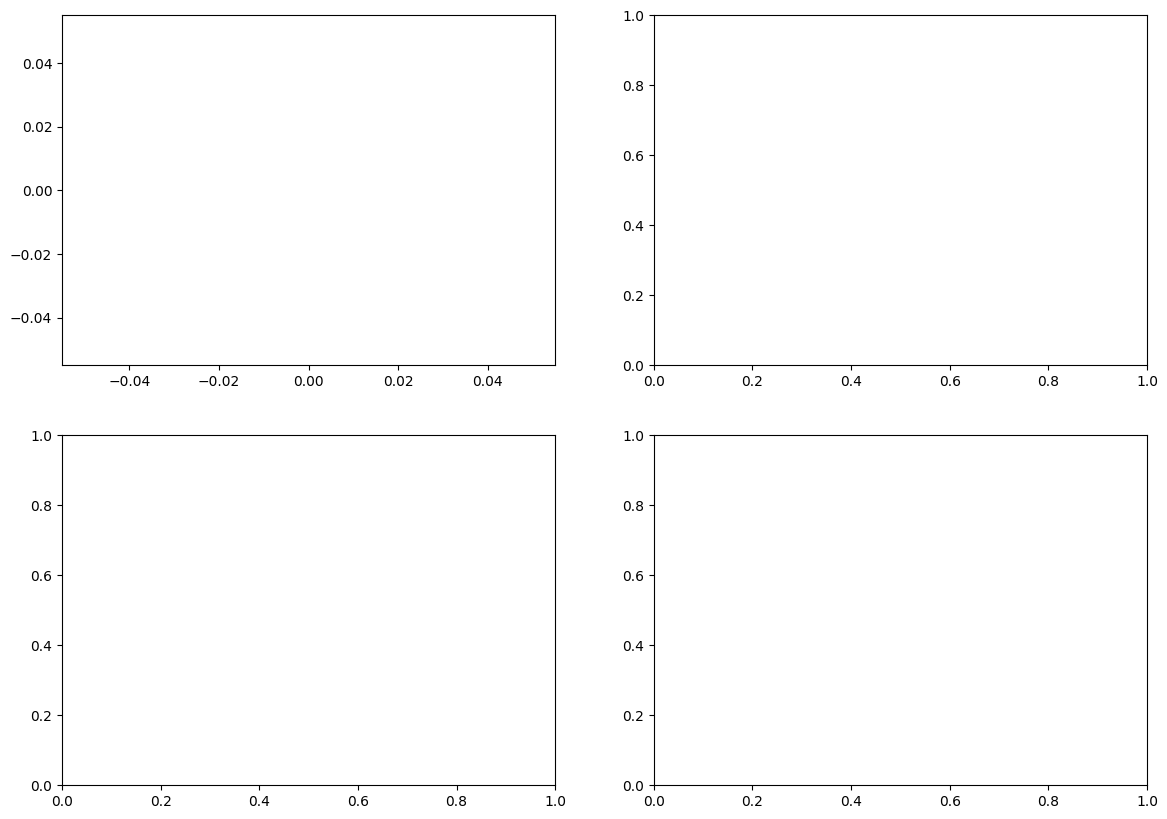

In [8]:
# Results visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cache hit rate
ax = axes[0, 0]
ax.plot(results['cache_history'], alpha=0.5)
window = 100
smoothed = np.convolve(results['cache_history'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(results['cache_history'])), smoothed, 'r-', lw=2, label=f'Smoothed (w={window})')
ax.axhline(np.mean(results['cache_history']), color='g', linestyle='--', label=f'Mean: {np.mean(results["cache_history"]):.2%}')
for i in range(1, CONFIG['num_games']):
    ax.axvline(i * CONFIG['steps_per_game'], color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Cache Hit Rate')
ax.set_title('Cache Performance Over Training')
ax.legend()

# Expert usage heatmap
ax = axes[0, 1]
usage_matrix = np.zeros((CONFIG['num_games'], CONFIG['num_experts']))
for gid, usage in results['expert_usage'].items():
    for eid, count in usage.items():
        if eid < CONFIG['num_experts']:
            usage_matrix[gid, eid] = count
usage_matrix = usage_matrix / (usage_matrix.sum(axis=1, keepdims=True) + 1e-8)
im = ax.imshow(usage_matrix, aspect='auto', cmap='hot')
ax.set_xlabel('Expert ID')
ax.set_ylabel('Game ID')
ax.set_title('Expert Usage by Game (Normalized)')
plt.colorbar(im, ax=ax)

# Episode rewards
ax = axes[1, 0]
for gid, rewards in results['rewards'].items():
    if rewards:
        ax.plot(rewards, label=f'Game {gid}', alpha=0.7)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode Rewards')
ax.legend()

# Expert overlap
ax = axes[1, 1]
def get_top_k(usage_dict, k=10):
    return set(e for e, _ in sorted(usage_dict.items(), key=lambda x: x[1], reverse=True)[:k])

overlap_matrix = np.zeros((CONFIG['num_games'], CONFIG['num_games']))
for i in range(CONFIG['num_games']):
    for j in range(CONFIG['num_games']):
        top_i = get_top_k(results['expert_usage'][i])
        top_j = get_top_k(results['expert_usage'][j])
        overlap_matrix[i, j] = len(top_i & top_j) / 10

im = ax.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
ax.set_xlabel('Game')
ax.set_ylabel('Game')
ax.set_title('Expert Overlap (Top 10)')
for i in range(CONFIG['num_games']):
    for j in range(CONFIG['num_games']):
        ax.text(j, i, f'{overlap_matrix[i,j]:.0%}', ha='center', va='center')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150)
plt.show()

In [ ]:
# Summary statistics
print('=' * 60)
print('TRAINING SUMMARY')
print('=' * 60)

print(f'\nOverall cache hit rate: {np.mean(results["cache_history"]):.2%}')
print(f'Final cache hit rate: {np.mean(results["cache_history"][-500:]):.2%}')

print('\nPer-game statistics:')
for gid in range(CONFIG['num_games']):
    usage = results['expert_usage'][gid]
    rewards = results['rewards'][gid]
    top5 = sorted(usage.items(), key=lambda x: x[1], reverse=True)[:5]
    total = sum(usage.values())
    print(f'\n  Game {gid}:')
    print(f'    Unique experts: {len(usage)}')
    print(f'    Top 5 experts: {[(e, f"{c/total:.1%}") for e, c in top5]}')
    print(f'    Avg episode reward: {np.mean(rewards) if rewards else 0:.2f}')

print('\nExpert specialization (low overlap = good specialization):')
overlaps = []
for i in range(CONFIG['num_games']):
    for j in range(i+1, CONFIG['num_games']):
        top_i = get_top_k(results['expert_usage'][i])
        top_j = get_top_k(results['expert_usage'][j])
        overlap = len(top_i & top_j)
        overlaps.append(overlap)
        print(f'  Game {i} vs {j}: {overlap}/10 experts overlap')
print(f'  Average overlap: {np.mean(overlaps):.1f}/10')

In [ ]:
# Save results
import json

save_data = {
    'config': CONFIG,
    'cache_history': results['cache_history'],
    'expert_usage': {int(k): dict(v) for k, v in results['expert_usage'].items()},
    'rewards': {int(k): list(v) for k, v in results['rewards'].items()},
    'summary': {
        'mean_cache_hit': float(np.mean(results['cache_history'])),
        'final_cache_hit': float(np.mean(results['cache_history'][-500:])),
        'avg_overlap': float(np.mean(overlaps)),
    }
}

with open('results.json', 'w') as f:
    json.dump(save_data, f, indent=2)

print('Results saved to results.json')
files.download('results.json')
files.download('training_results.png')